In [2]:
invisible(library(tidyverse))
set.seed('2019')
crime_data <- read.csv('./data/train_temp.csv')
str(crime_data)

'data.frame':	1000 obs. of  5 variables:
 $ X.1       : int  571005 630341 789265 459383 826316 174362 537069 631470 45896 161815 ...
 $ Category  : Factor w/ 33 levels "ARSON","ASSAULT",..: 30 7 31 4 24 14 14 14 33 28 ...
 $ PdDistrict: Factor w/ 10 levels "BAYVIEW","CENTRAL",..: 8 1 1 5 1 4 6 5 8 5 ...
 $ X         : num  -122 -122 -122 -122 -122 ...
 $ Y         : num  37.8 37.7 37.7 37.8 37.7 ...


In [3]:
sum(is.na(crime_data))

[1] 0

In [5]:
# 1. PdDistrict

# Patrol divisions are broken down into two divisions Golden Gate Division and Metro Division which are each led by San Francisco Police Commanders.
# https://en.wikipedia.org/wiki/San_Francisco_Police_Department
metro_div <- c("CENTRAL", "INGLESIDE", "NORTHERN", "SOUTHERN", "TENDERLOIN")
golden_gate_div <- c("BAYVIEW", "MISSION", "PARK", "RICHMOND", "TARAVAL")
crime_data <- crime_data %>%
  mutate(
    PatrolDivision = factor(case_when(
      PdDistrict %in% metro_div ~ "Metro",
      PdDistrict %in% golden_gate_div ~ "GoldenGate"
  )))
str(crime_data)

'data.frame':	1000 obs. of  6 variables:
 $ X.1           : int  571005 630341 789265 459383 826316 174362 537069 631470 45896 161815 ...
 $ Category      : Factor w/ 33 levels "ARSON","ASSAULT",..: 30 7 31 4 24 14 14 14 33 28 ...
 $ PdDistrict    : Factor w/ 10 levels "BAYVIEW","CENTRAL",..: 8 1 1 5 1 4 6 5 8 5 ...
 $ X             : num  -122 -122 -122 -122 -122 ...
 $ Y             : num  37.8 37.7 37.7 37.8 37.7 ...
 $ PatrolDivision: Factor w/ 2 levels "GoldenGate","Metro": 2 1 1 2 1 1 1 2 2 2 ...


'data.frame':	1000 obs. of  8 variables:
 $ X.1           : int  571005 630341 789265 459383 826316 174362 537069 631470 45896 161815 ...
 $ Category      : Factor w/ 33 levels "ARSON","ASSAULT",..: 30 7 31 4 24 14 14 14 33 28 ...
 $ PdDistrict    : Factor w/ 10 levels "BAYVIEW","CENTRAL",..: 8 1 1 5 1 4 6 5 8 5 ...
 $ X             : num  -122 -122 -122 -122 -122 ...
 $ Y             : num  37.8 37.7 37.7 37.8 37.7 ...
 $ PatrolDivision: Factor w/ 2 levels "GoldenGate","Metro": 2 1 1 2 1 1 1 2 2 2 ...
 $ PolarCoord_Rho: num  128 128 128 128 128 ...
 $ PolarCoord_Phi: num  -0.299 -0.299 -0.299 -0.299 -0.299 ...


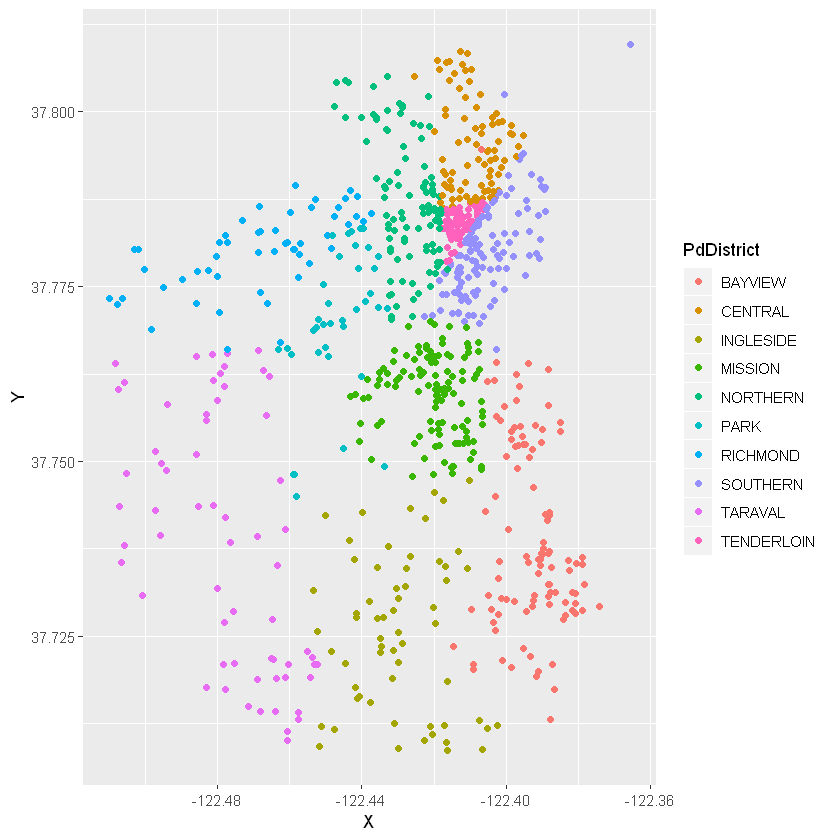

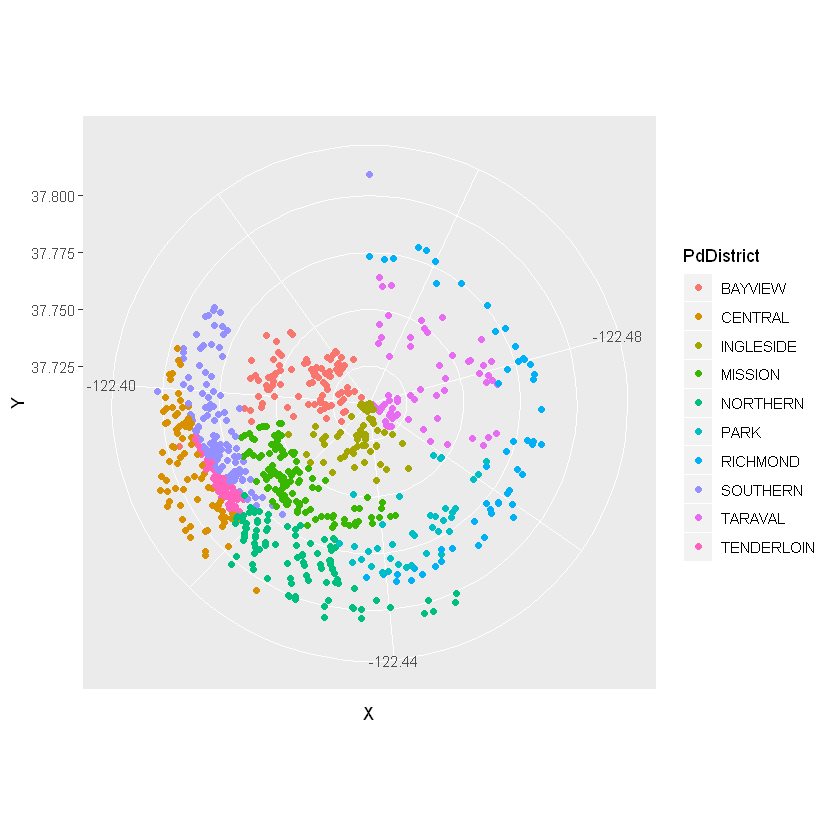

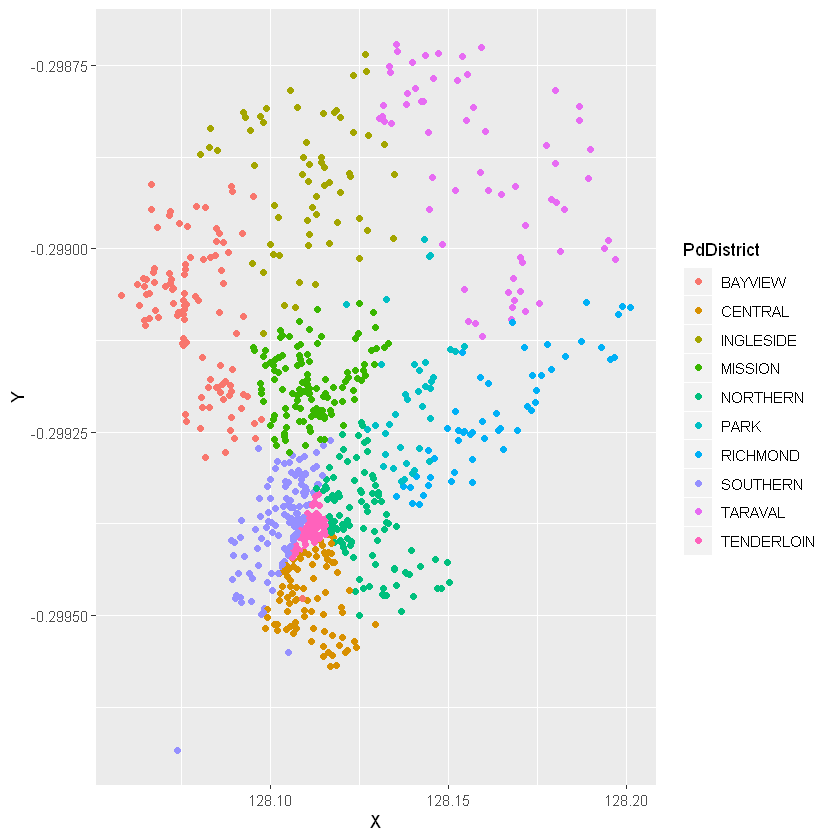

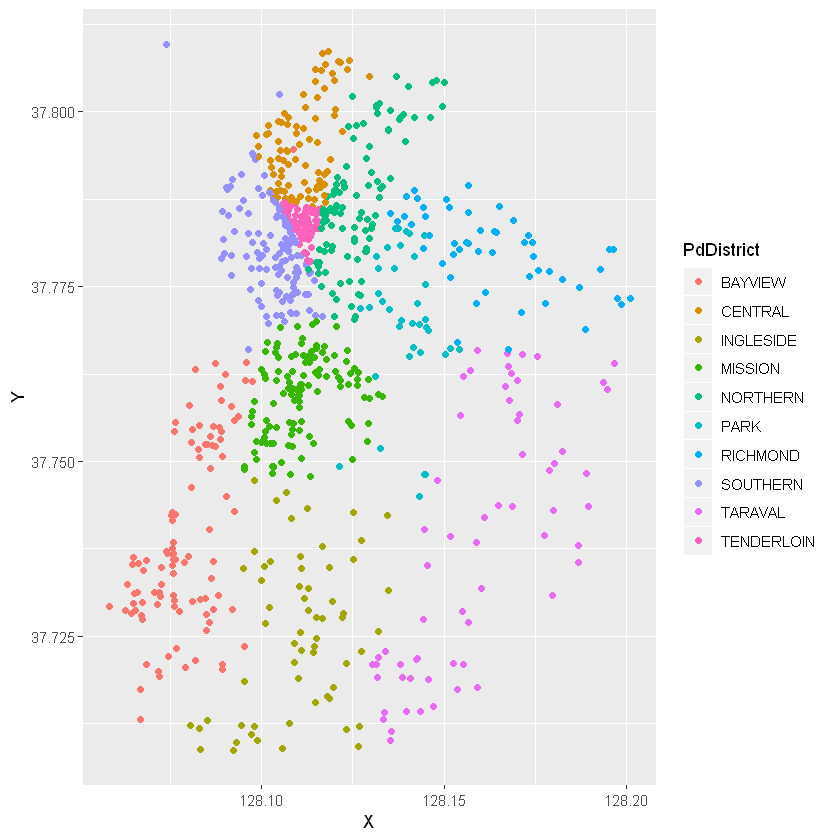

In [7]:
# 2. X and Y

# Polar coordinates
crime_data <- crime_data %>%
  mutate(
    PolarCoord_Rho = sqrt(X^2 + Y^2),
    PolarCoord_Phi = atan(Y / X)  
  )
str(crime_data)
plot <- ggplot(data = crime_data, aes(x = X, y = Y, color = PdDistrict))
plot + geom_point()
plot + geom_point() + coord_polar()
plot + geom_point(aes(x = PolarCoord_Rho, y = PolarCoord_Phi)) 
plot + geom_point(aes(x = PolarCoord_Rho, y = Y))

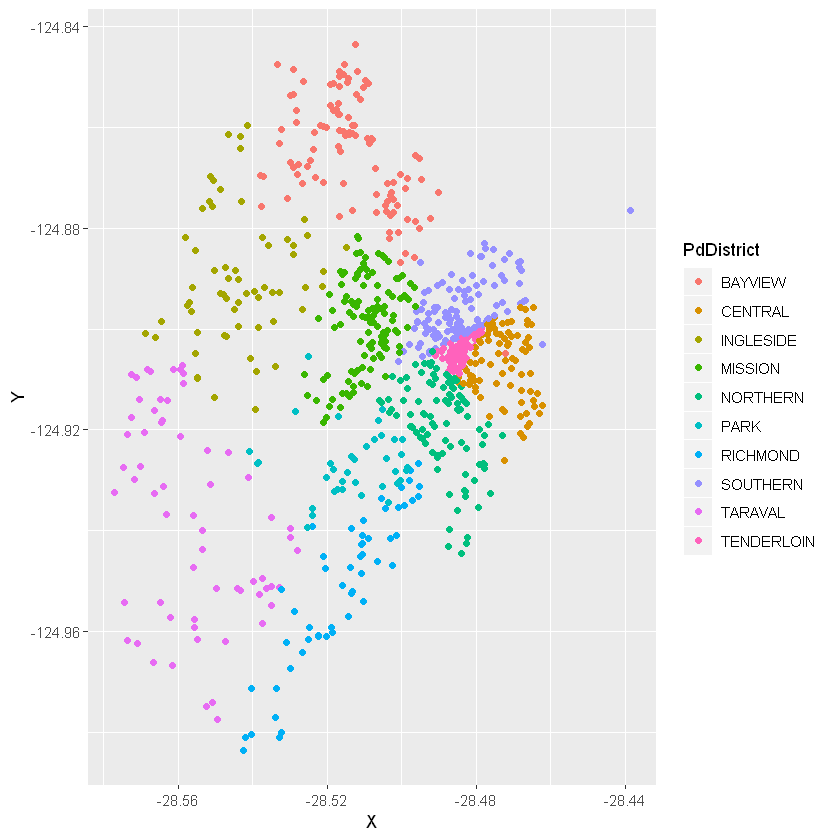

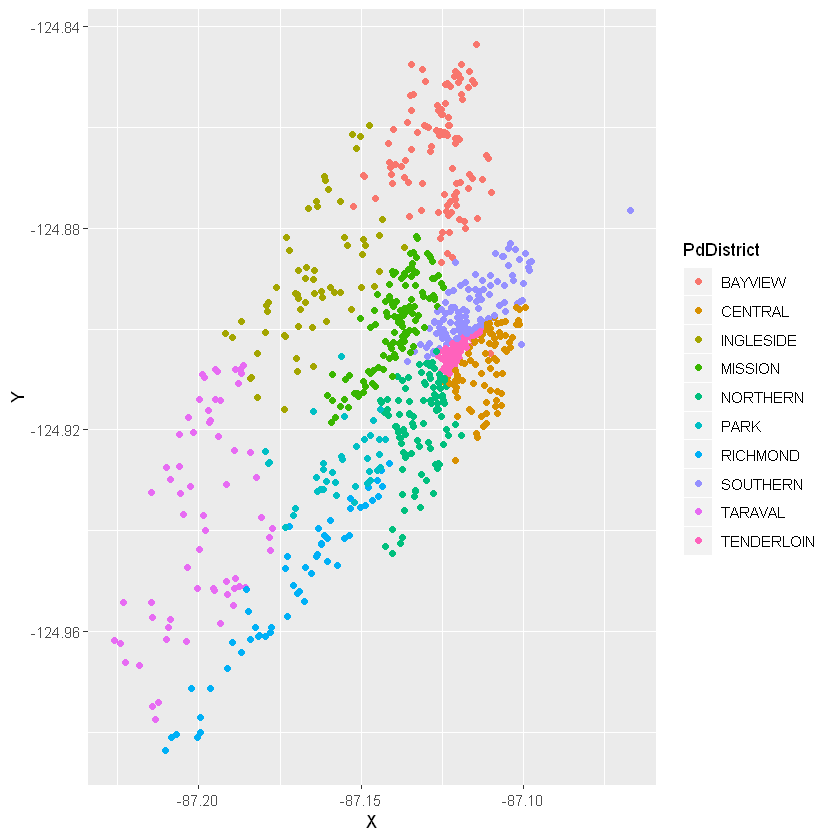

In [9]:
# Rotations 30, 45 and 60 degrees
crime_data <- crime_data %>%
  mutate(
    Rot_30_X = X * cos(pi / 6) + Y * sin(pi / 6),
    Rot_30_Y = X * sin(pi / 6) - Y * cos(pi / 6),
    Rot_45_X = X * cos(pi / 4) + Y * sin(pi / 4),
    Rot_45_Y = X * sin(pi / 4) - Y * cos(pi / 4),
    Rot_60_X = X * cos(pi / 3) + Y * sin(pi / 3),
    Rot_60_Y = X * sin(pi / 3) - Y * cos(pi / 3)
  )
plot + geom_point(data = crime_data, aes(x = Rot_60_X, y = Rot_60_Y))
plot + geom_point(data = crime_data, aes(x = Rot_30_X, y = Rot_60_Y))

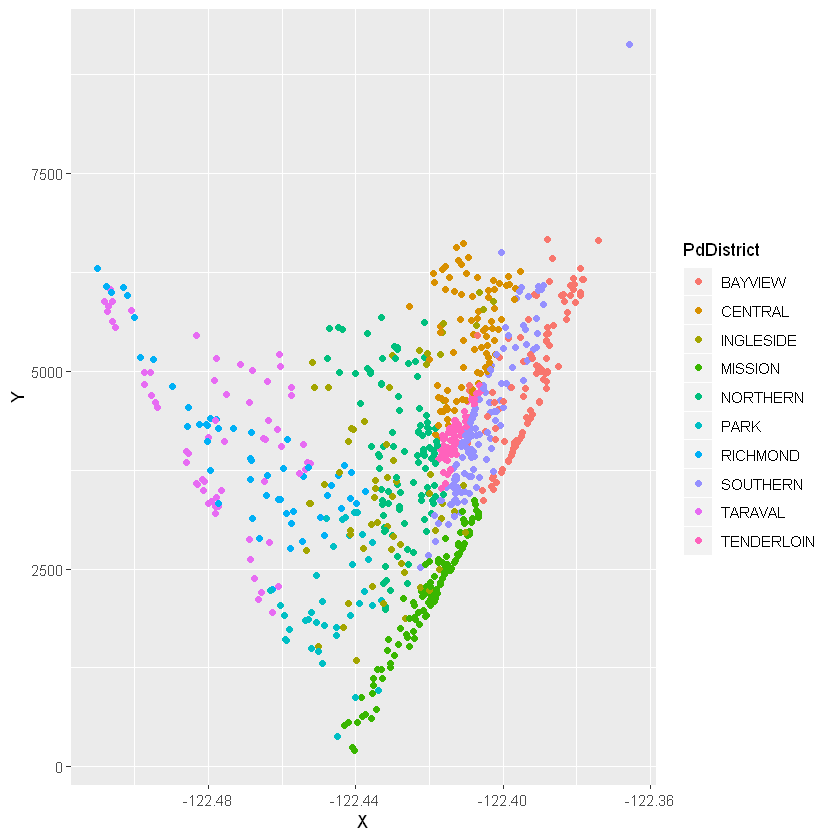

In [11]:
# Haversine distance or Great-circle distance 

# Exact center of city
# https://www.citylab.com/design/2016/06/exact-center-of-san-francisco/486341/
center_X <- -122.4425
center_Y <- 37.75454

# Helper functions
radians <- function(deg) {
  rad <- deg * pi / 180
  return(rad)
}
haversine <- function(X1, Y1, X2, Y2) {
  X1 <- radians(X1)
  Y1 <- radians(Y1)
  X2 <- radians(X2)
  Y2 <- radians(Y2)
  r <- 6378137 # Earth's radius in metres
  h <- sin((Y2 - Y1) / 2)^2 + cos(Y1) * cos(Y2) * sin((X2 - X1) / 2)^2
  d <- 2 * r * asin(sqrt(h))
  return(d)
}

crime_data <- crime_data %>%
  mutate(
    # TODO: More distances maybe? From downtown, etc?
    Haversine_Center = haversine(X, Y, center_X, center_Y)
  )
plot + geom_point(data = crime_data, aes(x = X, y = Haversine_Center, color = PdDistrict))

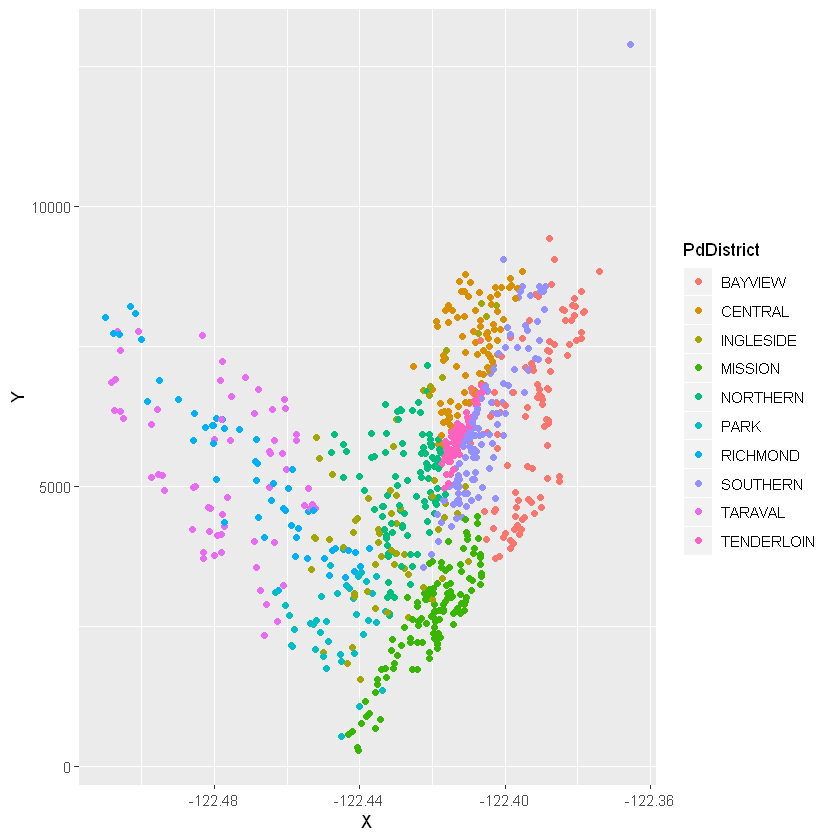

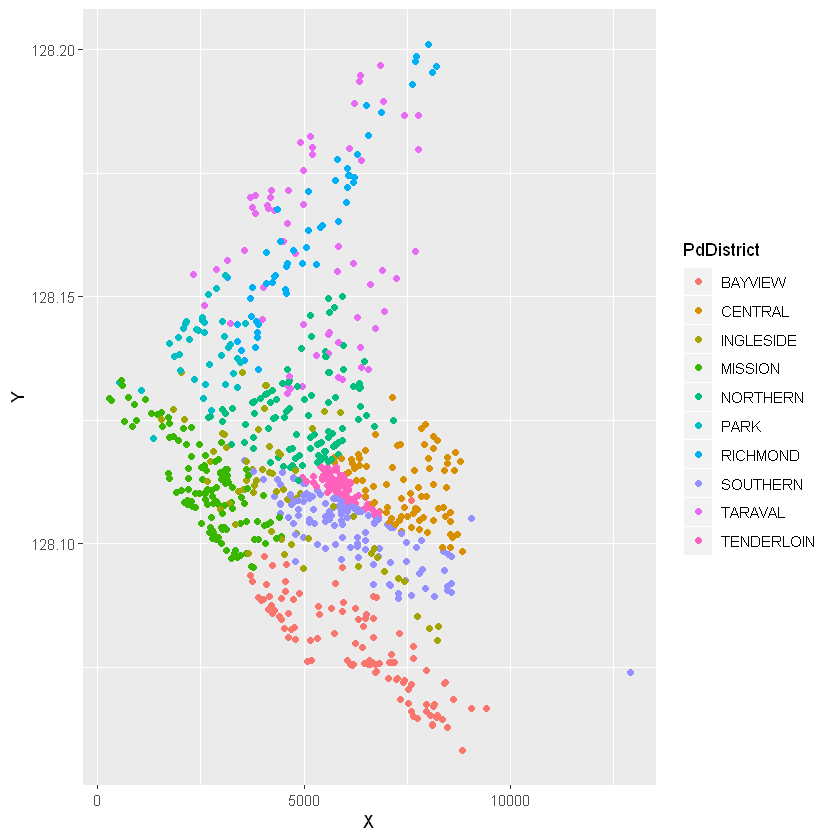

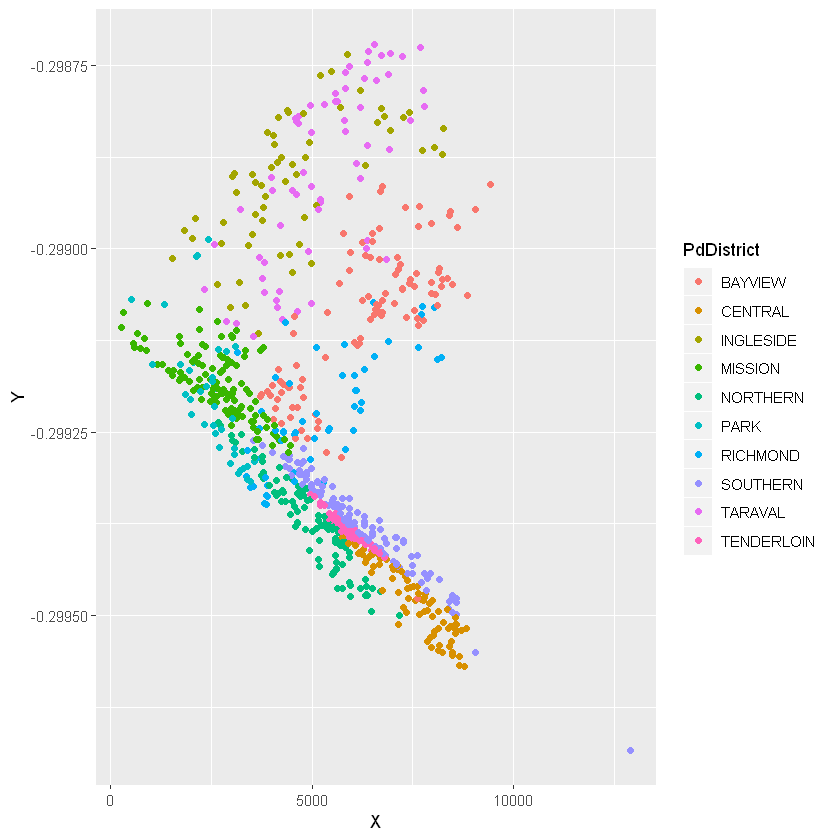

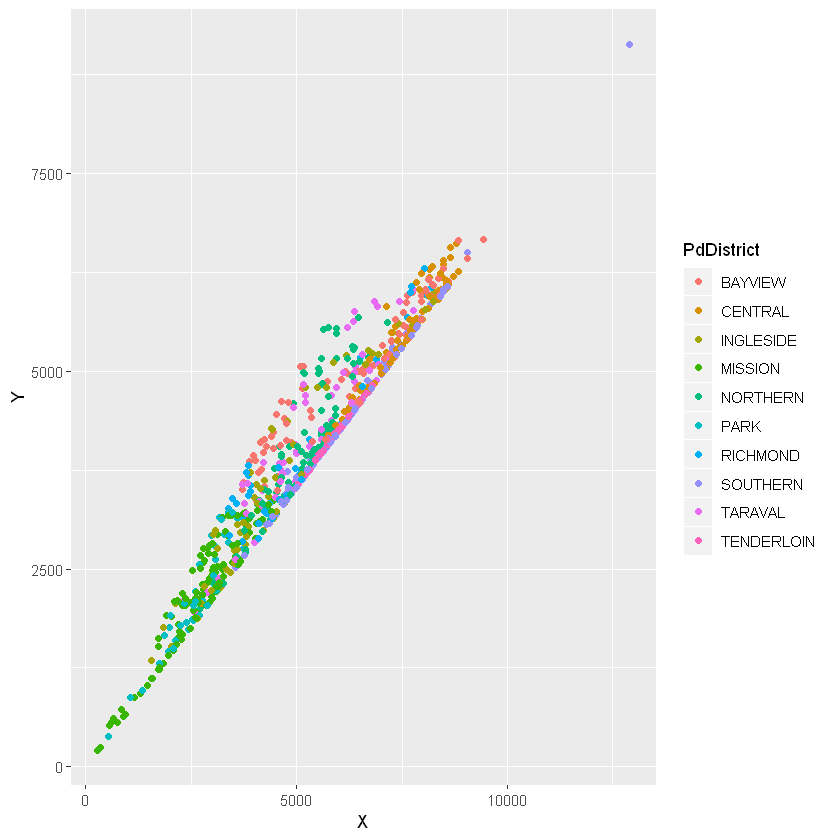

In [18]:
# Manhattan distance (L1-norm)
manhattan <- function(X1, Y1, X2, Y2) {
  lat_dist <- haversine(X1, Y1, X1, Y2)
  lon_dist <- haversine(X1, Y1, X2, Y1)
  man_dist <- lat_dist + lon_dist
  return(man_dist)
}
crime_data <- crime_data %>%
  mutate(
    # TODO: More distances maybe? From downtown, etc?
    Manhattan_Center = manhattan(X, Y, center_X, center_Y)
  )
plot + geom_point(data = crime_data, aes(x = X, y = Manhattan_Center, color = PdDistrict))
plot + geom_point(data = crime_data, aes(x = Manhattan_Center, y = PolarCoord_Rho, color = PdDistrict))
plot + geom_point(data = crime_data, aes(x = Manhattan_Center, y = PolarCoord_Phi, color = PdDistrict))
plot + geom_point(data = crime_data, aes(x = Manhattan_Center, y = Haversine_Center, color = PdDistrict))

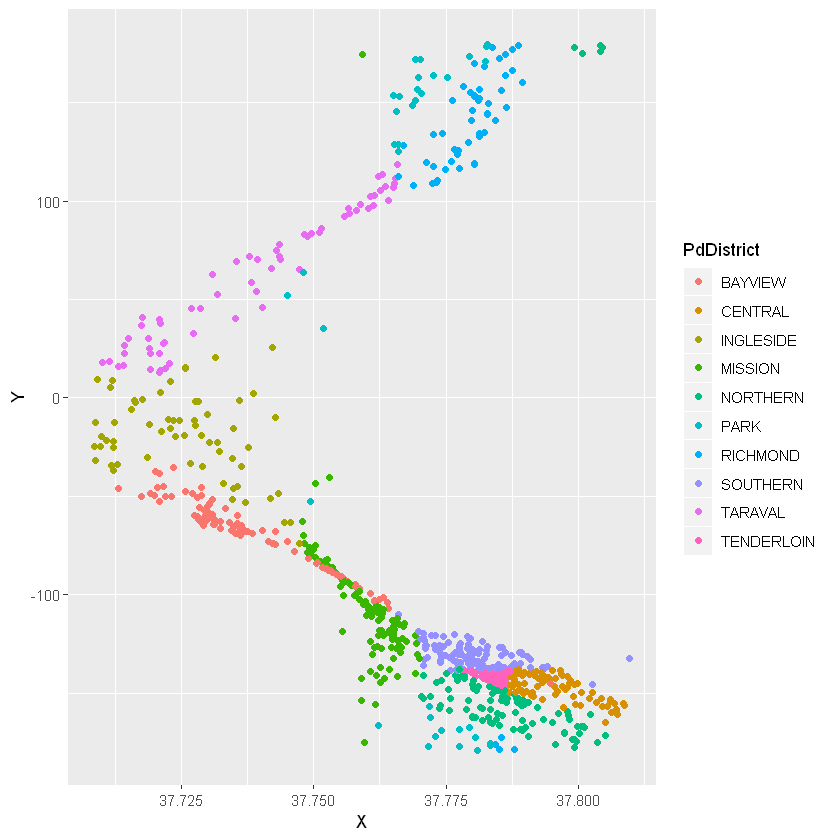

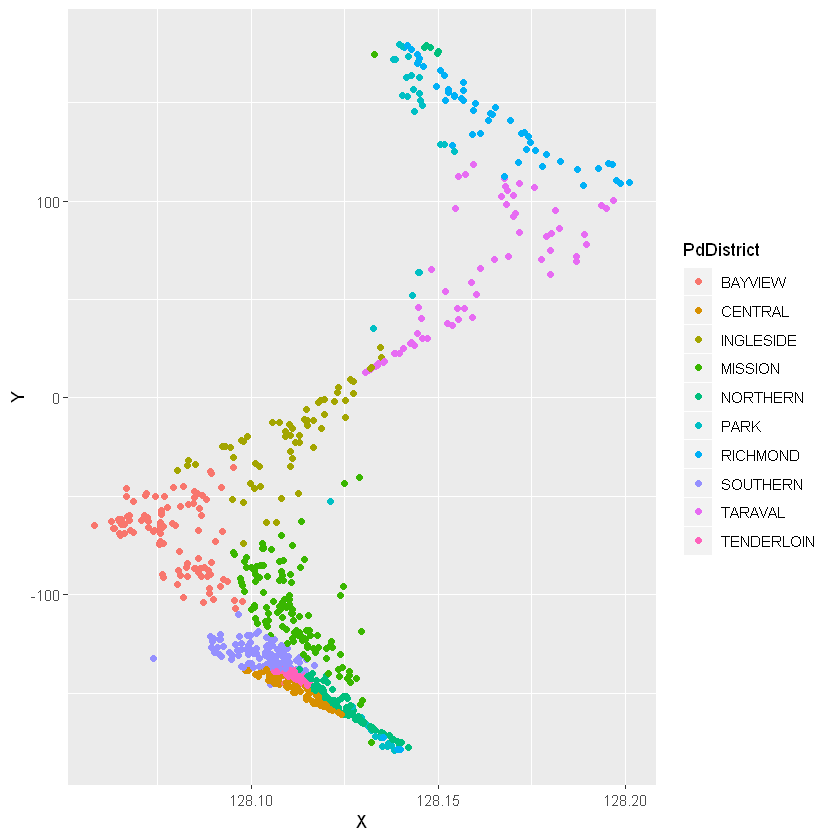

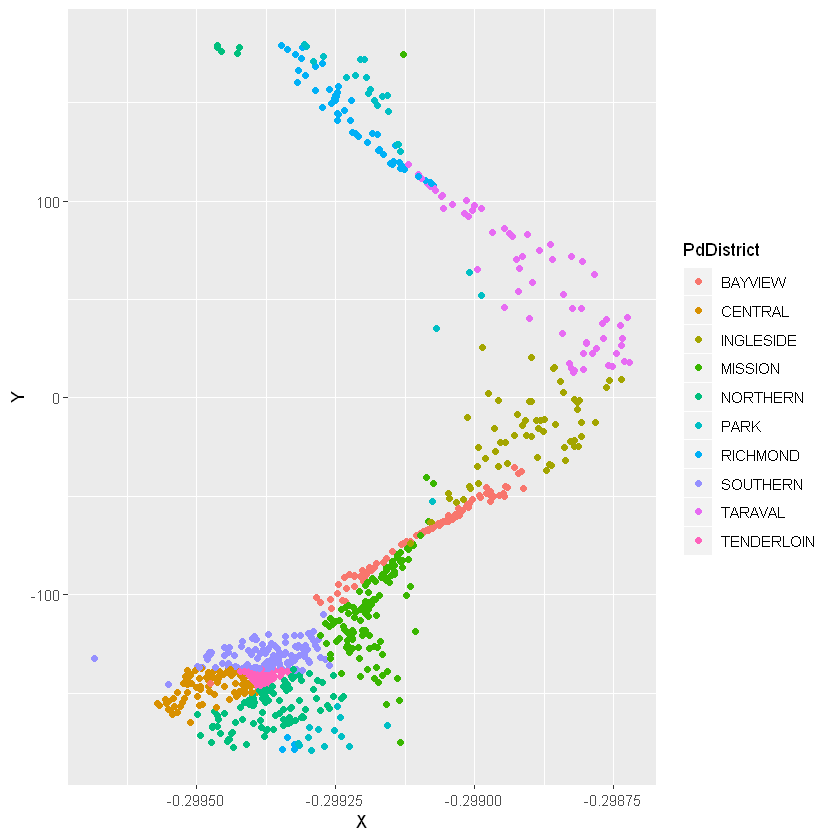

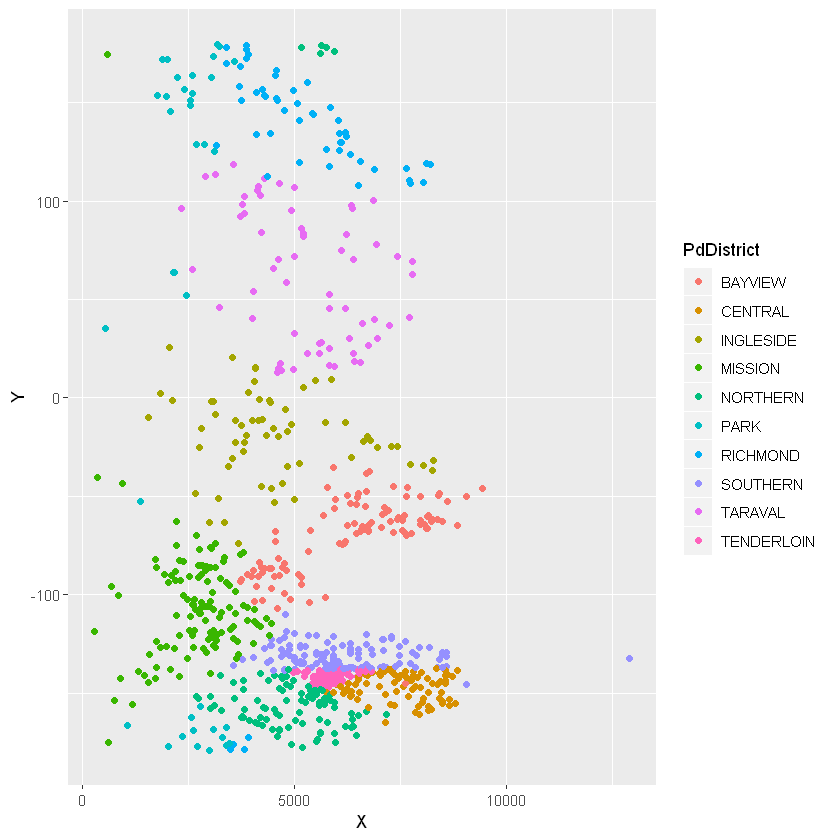

In [22]:
# Bearing degree of two points

# Helper functions
degrees <- function(rad) {
  deg <- rad * 180 / pi
  return(deg)
}
bearing <- function(X1, Y1, X2, Y2) {
  X1 <- radians(X1)
  Y1 <- radians(Y1)
  X2 <- radians(X2)
  Y2 <- radians(Y2)
  y <- sin(X2 - X1) * cos(Y2)
  x <- cos(Y1) * sin(Y2) - sin(Y1) * cos(Y2) * cos(X2 - X1)
  theta <- degrees(atan2(y, x))
  return(theta)
}

crime_data <- crime_data %>%
  mutate(
    # More distances maybe? From downtown, etc?
    Bearing_Center = bearing(X, Y, center_X, center_Y)
  )
plot + geom_point(data = crime_data, aes(x = Y, y = Bearing_Center, color = PdDistrict))
plot + geom_point(data = crime_data, aes(x = PolarCoord_Phi, y = Bearing_Center, color = PdDistrict))
plot + geom_point(data = crime_data, aes(x = Manhattan_Center, y = Bearing_Center, color = PdDistrict))

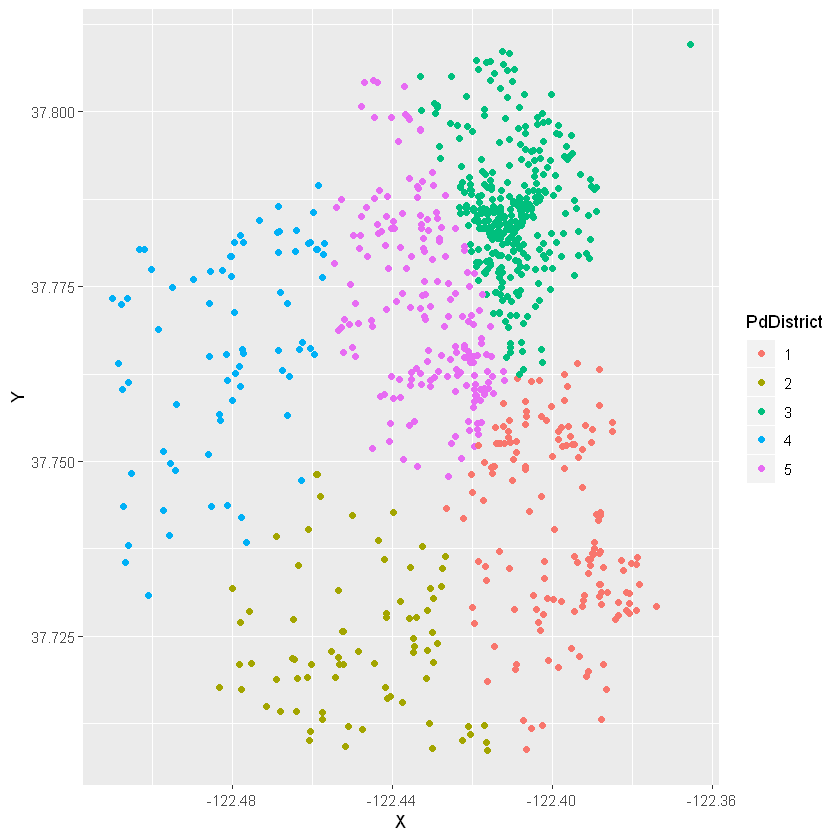

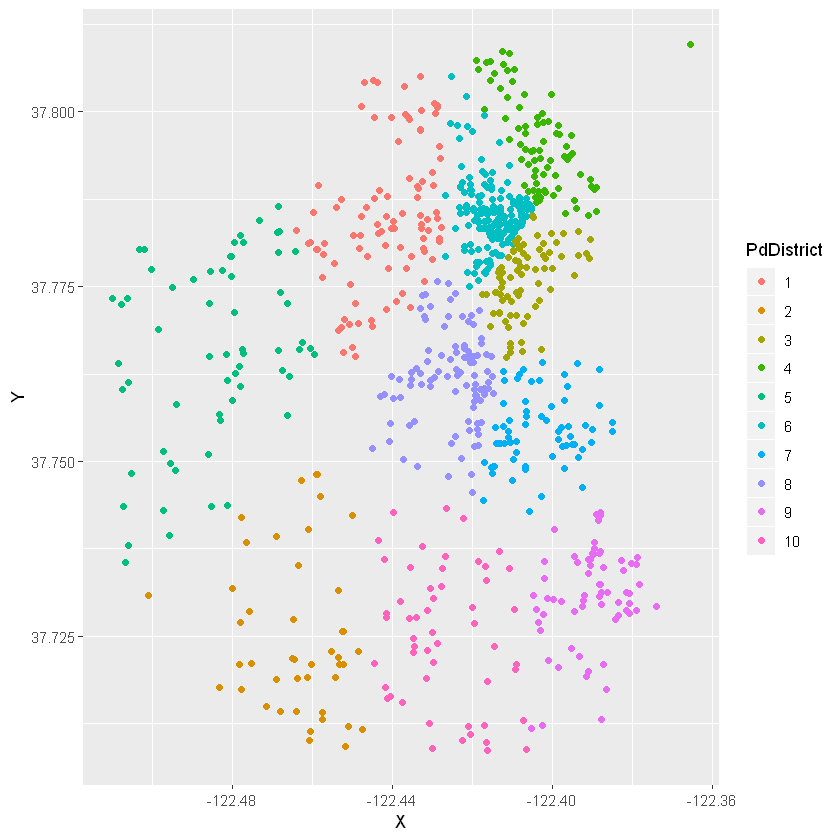

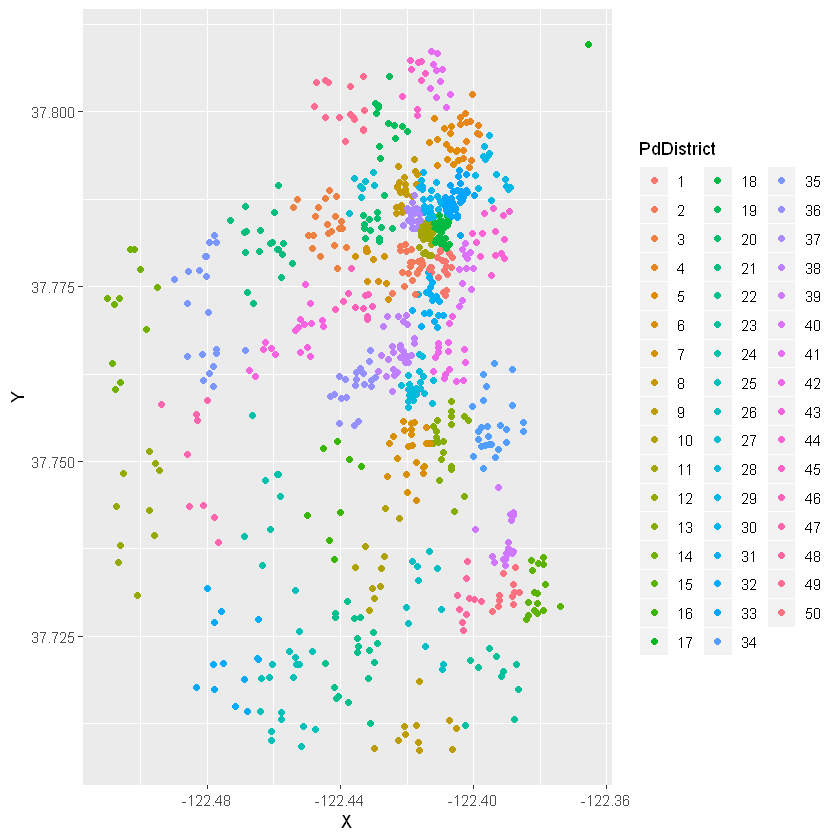

In [23]:
# Clustering using K-Means
model <- kmeans(crime_data[, c('X', 'Y')], 5)
crime_data$KMeans_Cluster <- factor(model$cluster)
plot + geom_point(data = crime_data, aes(color = KMeans_Cluster))

model <- kmeans(crime_data[, c('X', 'Y')], 10)
crime_data$KMeans_Cluster <- factor(model$cluster)
plot + geom_point(data = crime_data, aes(color = KMeans_Cluster))

# Now the outlier becomes obvious
model <- kmeans(crime_data[, c('X', 'Y')], 50)
crime_data$KMeans_Cluster <- factor(model$cluster)
plot + geom_point(data = crime_data, aes(color = KMeans_Cluster))

In [ ]:
# TODO: Rotation with Principal Component Analysis, Reverse-Geocoder, Geohash
# Reverse-Geocoder might be too expensive

In [24]:
# Test
library(datasauRus)
library(gganimate)
ggplot(datasaurus_dozen, aes(x = x, y = y)) +
  geom_point() +
  theme_minimal() +
  transition_states(dataset, 3, 1) + 
  ease_aes('cubic-in-out')


Rendering [>-------------------------------------------] at 7.6 fps ~ eta: 13s

Rendering [>-------------------------------------------] at 7.2 fps ~ eta: 13s

Rendering [=>------------------------------------------] at 7.1 fps ~ eta: 14s

Rendering [=>--------------------------------------------] at 7 fps ~ eta: 14s

Rendering [==>-------------------------------------------] at 7 fps ~ eta: 14s

Rendering [==>-------------------------------------------] at 7 fps ~ eta: 13s

Rendering [===>----------------------------------------] at 6.9 fps ~ eta: 13s

Rendering [===>----------------------------------------] at 6.8 fps ~ eta: 13s

Rendering [====>---------------------------------------] at 6.9 fps ~ eta: 13s

Rendering [=====>--------------------------------------] at 6.9 fps ~ eta: 13s

Rendering [=====>--------------------------------------] at 6.8 fps ~ eta: 13s

Rendering [======>-------------------------------------] at 6.9 fps ~ eta: 12s

Rendering [======>---------------------